In [331]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import roc_curve, auc
from scipy.io.arff import loadarff 

# from tf.keras.models import Sequential  # This does not work!
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM, CuDNNLSTM, Flatten
from tensorflow.python.keras.layers import BatchNormalization, Dropout, TimeDistributed
from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt

from time import time

def draw_roc_keras(model,xt, yt):
    predictions = model.predict(xt)
    # for in in range(2):
    fpr, tpr, thr = roc_curve(yt, predictions) #[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format('keras'))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return predictions

In [325]:
train_path="Data/FordA_TRAIN.arff"
test_path="Data/FordA_TEST.arff"

def read_ariff(path):
    raw_data, meta =loadarff(path)
    cols=[x for x in meta]
    data2d=np.zeros([raw_data.shape[0],len(cols)])
    for i,col in zip(range(len(cols)),cols):
        data2d[:,i]=raw_data[col]
    print(data2d.shape)
    return data2d

data2d=read_ariff(train_path)
test2d=read_ariff(test_path)
print(train2d.shape, test2d.shape)


(3601, 501)
(1320, 501)
(2808, 501) (1320, 501)


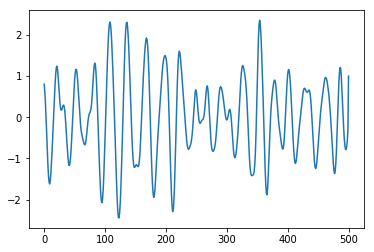

In [141]:
plt.plot(data2d[1,:])
plt.show()

Splitting into validation and training

In [109]:
failed=data2d[data2d[:,-1]==1]
not_failed=data2d[data2d[:,-1]==-1]
print(failed.shape, not_failed.shape)

train2d=np.concatenate((failed[:int(0.8*failed.shape[0])],
                       not_failed[:int(0.8*failed.shape[0])]),
                       axis=0)

val2d=np.concatenate((failed[int(0.8*failed.shape[0]):],
                       not_failed[int(0.8*failed.shape[0]):]),
                       axis=0)

np.random.shuffle(train2d)
np.random.shuffle(val2d)

print(train2d.shape, val2d.shape)

(1755, 501) (1846, 501)
(2808, 501) (793, 501)


Making 3d arrays

In [110]:
def make3d(data):
    df=data.copy()
    x,y=df.shape
    data3d=np.zeros([x,y-1,2])
    for i in range(x):
        data3d[i,:,0]=df[i][:-1].T
        data3d[i,:,1]=np.full((y-1),df[i][-1])
    return data3d

train3d=make3d(train2d)
val3d  =make3d(val2d)
test3d =make3d(test2d)
print(train3d.shape, val3d.shape, test3d.shape)

(2808, 500, 2) (793, 500, 2) (1320, 500, 2)


Scaling the data

In [201]:
def scale_d(data):
    df=data.copy()
    df_scaled=np.zeros(df.shape)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    stder = StandardScaler()
    # scaler = scaler.fit(df[0])
    for i in range(df.shape[0]):
        df_scaled[i,:,0]=stder.fit_transform(
                                         df[i,:,0].reshape((df.shape[1], 1))
                                         ).reshape((df.shape[1]))

        df_scaled[i,:,1]=df[i,:,1]
    return df_scaled

train_scaled=scale_d(train3d)
val_scaled  =scale_d(val3d)
test_scaled =scale_d(test3d)

x_train  =np.expand_dims(train_scaled[:,:,0],axis=2)
y_train  =train_scaled[:,:,1]
y_train_e=np.expand_dims(y_train,axis=2)
y_train_s=y_train[:,0]
y_train_s=np.array([1. if x==1 else 0. for x in y_train[:,0]])


x_val   =np.expand_dims(val_scaled[:,:,0],axis=2)
y_val   =val_scaled[:,:,1]
y_val_e =np.expand_dims(y_val,axis=2)
y_val_s =y_val[:,0]
y_val_s=np.array([1. if x==1 else 0. for x in y_val[:,0]])


x_test  =np.expand_dims(test_scaled[:,:,0],axis=2)
y_test  =test_scaled[:,:,1]
y_test_e=np.expand_dims(y_test,axis=2)
y_test_s=y_test[:,0]
y_test_s=np.array([1. if x==1 else 0. for x in y_test[:,0]])

print(x_train.shape,x_val.shape,x_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)
print(y_train_e.shape,y_val_e.shape,y_test_e.shape)
print(y_train_s.shape,y_val_s.shape,y_test_s.shape)


(2808, 500, 1) (793, 500, 1) (1320, 500, 1)
(2808, 500) (793, 500) (1320, 500)
(2808, 500, 1) (793, 500, 1) (1320, 500, 1)
(2808,) (793,) (1320,)


In [208]:
y_test_s

array([0., 0., 0., ..., 1., 1., 1.])

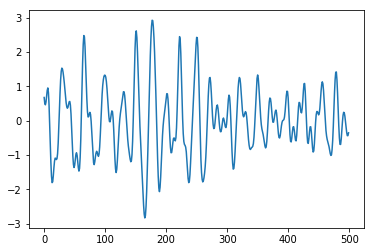

In [144]:
plt.plot(x_train[11,:,0])
plt.show()

Genereator function

In [177]:
def batch_generator(data_x,data_y,sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    df_x=data_x.copy()
    df_y=data_y.copy()
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (df_y.shape[0], sequence_length, df_y.shape[2])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(df_x.shape[0]):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(df_x.shape[1] - sequence_length)
#             print(idx,idx+sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = df_x[i,idx:idx+sequence_length,:]
            y_batch[i] = df_y[i,idx:idx+sequence_length,:]
        
        yield (x_batch, y_batch)
        
def batch_generator_s(data_x,data_y,sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    df_x=data_x.copy()
    df_y=data_y.copy()
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (df_y.shape[0], 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(df_x.shape[0]):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(df_x.shape[1] - sequence_length)
#             print(idx,idx+sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = df_x[i,idx:idx+sequence_length,:]
        y_batch = df_y
        
        yield (x_batch, y_batch)
        


In [178]:
gen_val=batch_generator(x_val,y_val_e,100)
x_batch,y_batch=next(gen_val)
print(x_batch.shape,y_batch.shape)

(793, 100, 1) (793, 100, 1)


Function to load best callback

In [283]:
class GetBest(Callback):
    """Get the best model at the end of training.
	# Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
	# Example
		callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
		mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)

# Creating the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_69 (CuDNNLSTM)    (None, 100)               41200     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.6881 - acc: 0.5285
Epoch 00001: val_acc improved from -inf to 0.60567, storing weights.
100/100 [==============================] - 8s 82ms/step - loss: 0.6877 - acc: 0.5294 - val_loss: 0.6625 - val_acc: 0.6057
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.5404 - acc: 0.7117
Epoch 00002: val_acc improved from 0.60567 to 0.75710, storing weights.
100/100 [==============================] - 4s 44ms/step - loss: 0.5395 - acc: 0.7124 - va

Epoch 30/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.8871
Epoch 00030: val_acc did not improve
100/100 [==============================] - 4s 45ms/step - loss: 0.2585 - acc: 0.8871 - val_loss: 0.3195 - val_acc: 0.8663
Epoch 31/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 0.8871
Epoch 00031: val_acc did not improve
100/100 [==============================] - 5s 45ms/step - loss: 0.2584 - acc: 0.8870 - val_loss: 0.3140 - val_acc: 0.8664
Epoch 32/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2554 - acc: 0.8881
Epoch 00032: val_acc did not improve
100/100 [==============================] - 5s 45ms/step - loss: 0.2553 - acc: 0.8881 - val_loss: 0.3159 - val_acc: 0.8678
Epoch 33/50
 98/100 [============================>.] - ETA: 0s - loss: 0.2540 - acc: 0.8888
Epoch 00033: val_acc did not improve
100/100 [==============================] - 5s 45ms/step - loss: 0.2540 - acc: 0.8889 - val_loss: 0.3273 - val_acc: 0.8

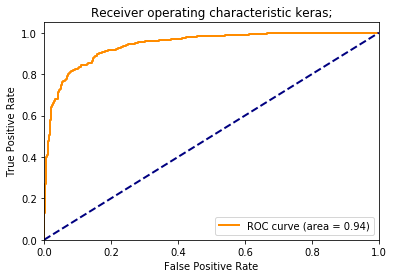

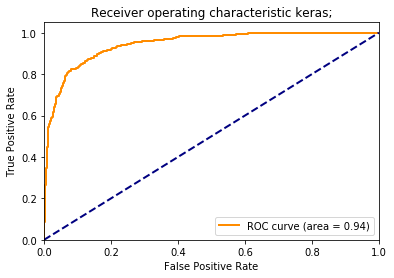

acc: 87.05%


In [316]:
seq_len=100
STEPS = 100
EPOCHS= 50

NAME = "fordA-{}".format(int(time()))
model = Sequential()


# model.add(BatchNormalization(input_shape=(seq_len,1)))
model.add(CuDNNLSTM(units=100,
              return_sequences=False,
              input_shape=(seq_len,1)))

# model.add(Dropout(0.5))
# model.add(CuDNNLSTM(units=100,
#               return_sequences=True,
#               input_shape=(seq_len,1)))
# model.add(Dropout(0.5))

# model.add(CuDNNLSTM(units=50, return_sequences=False))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


gen_train=batch_generator_s(x_train,y_train_s,seq_len)

gen_val  =batch_generator_s(x_val,y_val_s,seq_len)

tensorboard=TensorBoard(log_dir='Logs/{}'.format(NAME))

checkp=ModelCheckpoint('Models/best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

best=GetBest(monitor='val_acc', verbose=1, mode='max')

callbacks=[best, tensorboard]

model.fit_generator(generator=gen_train,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_data =gen_val,
                    validation_steps =STEPS,
                    callbacks=callbacks
                   )
pred=draw_roc_keras(model,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model,[x_test[:,-seq_len:,:]],y_test_s)
scores = model.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

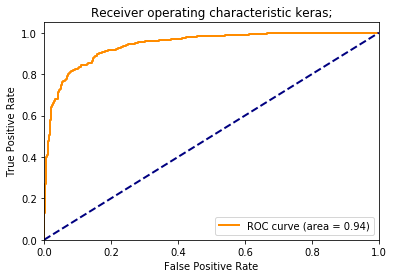

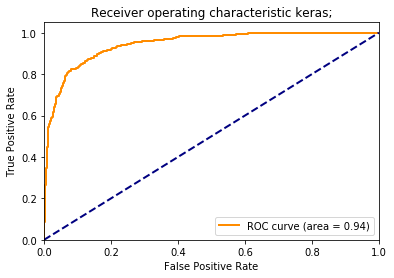

acc: 87.05%


In [318]:
pred=draw_roc_keras(model,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model,[x_test[:,-seq_len:,:]],y_test_s)
scores = model.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [319]:
# # load weights
# model.load_weights("Models/best.hdf5")
# # Compile model (required to make predictions)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print("Created model and loaded weights from file")
# # load pima indians dataset
# # # estimate accuracy on whole dataset using loaded weights
# # scores = model.evaluate(X, Y, verbose=0)
# # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# pred=draw_roc_keras(model,[x_test[:,-seq_len:,:]],y_test_s)


In [320]:
scores = model.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 87.05%


Time distributed

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_90 (CuDNNLSTM)    (None, 100, 100)          41200     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 100, 100)          10100     
_________________________________________________________________
flatten_12 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               1000100   
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 101       
Total params: 1,051,501
Trainable params: 1,051,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 0.5751 - acc: 0.6914
Epoch 00001: val_acc improved from -inf to

49/50 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.8870
Epoch 00028: val_acc improved from 0.88101 to 0.88101, storing weights.
50/50 [==============================] - 3s 60ms/step - loss: 0.2602 - acc: 0.8872 - val_loss: 0.2806 - val_acc: 0.8810
Epoch 29/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2606 - acc: 0.8862
Epoch 00029: val_acc improved from 0.88101 to 0.88149, storing weights.
50/50 [==============================] - 3s 59ms/step - loss: 0.2608 - acc: 0.8861 - val_loss: 0.2820 - val_acc: 0.8815
Epoch 30/100
49/50 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.8881
Epoch 00030: val_acc improved from 0.88149 to 0.88343, storing weights.
50/50 [==============================] - 3s 59ms/step - loss: 0.2603 - acc: 0.8881 - val_loss: 0.2849 - val_acc: 0.8834
Epoch 31/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2562 - acc: 0.8868
Epoch 00031: val_acc did not improve
50/50 [=============================

Epoch 61/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2330 - acc: 0.9000
Epoch 00061: val_acc did not improve
50/50 [==============================] - 3s 59ms/step - loss: 0.2327 - acc: 0.9002 - val_loss: 0.2914 - val_acc: 0.8789
Epoch 62/100
48/50 [===========================>..] - ETA: 0s - loss: 0.2293 - acc: 0.9015
Epoch 00062: val_acc did not improve
50/50 [==============================] - 3s 60ms/step - loss: 0.2292 - acc: 0.9015 - val_loss: 0.2913 - val_acc: 0.8790
Epoch 63/100
49/50 [============================>.] - ETA: 0s - loss: 0.2299 - acc: 0.9014
Epoch 00063: val_acc did not improve
50/50 [==============================] - 3s 60ms/step - loss: 0.2299 - acc: 0.9014 - val_loss: 0.3014 - val_acc: 0.8746
Epoch 64/100
49/50 [============================>.] - ETA: 0s - loss: 0.2270 - acc: 0.9025
Epoch 00064: val_acc did not improve
50/50 [==============================] - 3s 59ms/step - loss: 0.2269 - acc: 0.9025 - val_loss: 0.3000 - val_acc: 0.8744
Epoch 65

49/50 [============================>.] - ETA: 0s - loss: 0.1815 - acc: 0.9224
Epoch 00094: val_acc did not improve
50/50 [==============================] - 3s 59ms/step - loss: 0.1817 - acc: 0.9224 - val_loss: 0.3559 - val_acc: 0.8662
Epoch 95/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1777 - acc: 0.9250
Epoch 00095: val_acc did not improve
50/50 [==============================] - 3s 60ms/step - loss: 0.1774 - acc: 0.9251 - val_loss: 0.3571 - val_acc: 0.8653
Epoch 96/100
49/50 [============================>.] - ETA: 0s - loss: 0.1800 - acc: 0.9240
Epoch 00096: val_acc did not improve
50/50 [==============================] - 3s 59ms/step - loss: 0.1798 - acc: 0.9241 - val_loss: 0.3639 - val_acc: 0.8655
Epoch 97/100
48/50 [===========================>..] - ETA: 0s - loss: 0.1750 - acc: 0.9259
Epoch 00097: val_acc did not improve
50/50 [==============================] - 3s 60ms/step - loss: 0.1751 - acc: 0.9260 - val_loss: 0.3701 - val_acc: 0.8607
Epoch 98/100
48/50 [=

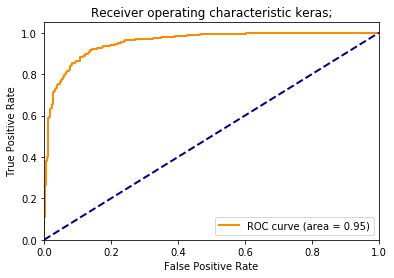

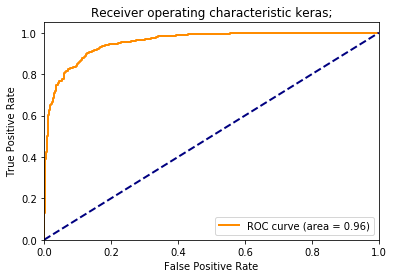

acc: 87.95%


In [351]:
seq_len=100
STEPS = 50
EPOCHS= 100

NAME = "td_fordA-{}".format(int(time()))
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(CuDNNLSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

# model_d.add(Dropout(0.5))
model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_d.add(Flatten())
# model_d.add(Dropout(0.5))
model_d.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))


model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d.summary()


gen_train=batch_generator_s(x_train,y_train_s,seq_len)

gen_val  =batch_generator_s(x_val,y_val_s,seq_len)

tensorboard=TensorBoard(log_dir='Logs/{}'.format(NAME))

checkp=ModelCheckpoint('model_ds/best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

best=GetBest(monitor='val_acc', verbose=1, mode='max')

callbacks=[best, tensorboard]

model_d.fit_generator(generator=gen_train,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_data =gen_val,
                    validation_steps =STEPS,
                    callbacks=callbacks
                   )
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

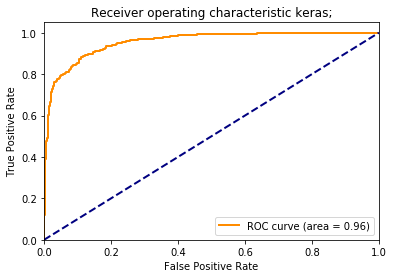

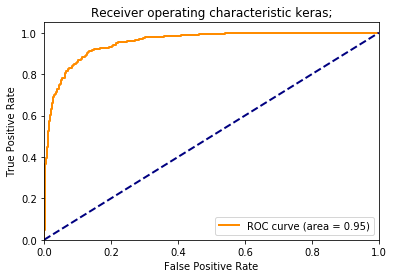

acc: 88.03%


In [348]:
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))